In [ ]:
# ! pip uninstall opencv-python-headless
# ! pip install opencv-python-headless==4.1.2.30
# ! pip install imgaug==0.4.0
# ! pip install matplotlib==3.3.4
# ! pip install -U albumentations

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from imgaug import augmenters as iaa
import imgaug as ia
from keras.preprocessing.image import ImageDataGenerator
from math import pi
from keras.callbacks import ModelCheckpoint
import pickle           
import os, shutil
from scipy.stats import mode
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import albumentations as A
from albumentations import Compose, ToFloat, RandomBrightnessContrast, CoarseDropout, ShiftScaleRotate, Affine, Solarize, Posterize, Blur, HorizontalFlip
from functools import partial

In [ ]:
assert ia.__version__ == '0.4.0'

# Download data, defining constants and parameters

In [ ]:
# Download Dataset
FILENAME = 'imagenette2-320'
path_to_folder = tf.keras.utils.get_file(
    FILENAME,
    "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz",
    untar=True)

# Defining constants and parameters
dst = "folder"
TRAIN_PATH = dst+"/train"
VAL_PATH = dst+"/val"
class_names = ['0-Fish', '1-Dog', '2-Soundsystem', '3-Chainsaw', '4-Cathedral', '5-French Horn', '6-Truck', '7-Gas Station', '8-Golf', '9-Parachute'  ]
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
NUM_CLASSES = 10
EPOCHS = 50
IMAGE_SIZE = 224
MINOR_FRAC = 0.1
REPEAT = 1
MINOR_CLASSES = [i for i in range(5,10)]
MAJOR_CLASSES = [i for i in range(5)]
NUM_CLASSES = 10
VAL_SPLIT_RATE = 0.2
N_AUG = 2 # N - RandAugment
M_AUG = 9 # M - RandAugment
FOLDS = 5


from google.colab import drive
drive.mount('/content/drive')
EFFICIENT_MODEL_PATH =  '/content/drive/My Drive/AugModels/base_model'
MODELS_PATH = '/content/drive/My Drive/AugModels/rgb'
HISTORY_PATH = '/content/drive/My Drive/AugModels/history'
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creating unbalanced dataset

In [ ]:
FRAC = 0.2
if os.path.exists(dst) and os.path.isdir(dst):
    shutil.rmtree(dst)
shutil.copytree(path_to_folder,  dst)
train_folder = os.path.join(dst, "train")
test_folder = os.path.join(dst, "val")

for i,label in enumerate(sorted(os.listdir(train_folder))):
    src = os.path.join(test_folder, label)
    dest = os.path.join(train_folder, label)
    filenames= os.listdir(src)
    l = len(filenames)
    files_to_move = filenames[0:int(l/2)]
    for file_name in files_to_move:
        shutil.move(os.path.join(src, file_name), os.path.join(dest, file_name))

random.seed(1)
for i,label in enumerate(sorted(os.listdir(train_folder))):
    src = os.path.join(train_folder, label)
    if i>=5:
        filenames= os.listdir(src)
        l = len(filenames)
        files_to_remove = random.sample(filenames, int((1-FRAC)*l))
        for file_name in files_to_remove:
            os.remove(os.path.join(src, file_name))

# Defining pipelines based on different augmentations schemes
- Defining augmentations functions
- Creating tf.dataset and mapping augmentations
- Defining visualization functions

In [ ]:
augs_list_basic = [RandomBrightnessContrast(p=0.5), 
                   HorizontalFlip(p=0.5), 
                   ShiftScaleRotate(p=0.5), 
                   ToFloat()]
augs_list_randaugment = [RandomBrightnessContrast(p=0.5), 
                   HorizontalFlip(p=0.5), 
                   ShiftScaleRotate(p=0.5),
                   Solarize(p=0.5),
                   Posterize(p=0.5),
                   Affine(shear={'x':(-45,45)}, p=0.5),
                   Affine(shear={'y':(-45,45)}, p=0.5),
                   CoarseDropout(p=0.5),
                   Blur(p=0.5),
                   ToFloat()]


def randaugment(images, n=N_AUG, m=M_AUG):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    rand_aug = iaa.RandAugment(n=n, m=m)
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())


def create_minority(label):
    # random.seed(1)
    if label in MINOR_CLASSES:  
        return tf.constant(random.random()<MINOR_FRAC)
    else:
        return tf.constant(True)

def rescale_and_encode_labels(ds, rescale=True):
  ds_scaled = ds.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES))).prefetch(AUTO)
  if rescale:
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds_scaled = ds_scaled.map(lambda x, y: (normalization_layer(x), y))
  return ds_scaled

def aug_fn(image):
  transforms = Compose(augs_list_basic)
  data = {"image":image}
  aug_data = transforms(**data)
  aug_img = aug_data["image"]
  return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label


def aug_fn_advanced(image):
  transforms = Compose(augs_list_randaugment)
  data = {"image":image}
  aug_data = transforms(**data)
  aug_img = aug_data["image"]
  return aug_img

def process_data_advanced(image, label):
    aug_img = tf.numpy_function(func=aug_fn_advanced, inp=[image], Tout=tf.float32)
    return aug_img, label

def create_ds(kind=None, seed=0, include_scale_encode=None, color='rgb'):
  train_ds = tf.keras.utils.image_dataset_from_directory(
      TRAIN_PATH, color_mode=color,
      validation_split=VAL_SPLIT_RATE,
      subset="training",
      image_size=(IMAGE_SIZE,IMAGE_SIZE),
      seed=seed,
      batch_size=BATCH_SIZE,
      shuffle=True
  )

  val_ds = tf.keras.utils.image_dataset_from_directory(
      TRAIN_PATH, color_mode=color,
      validation_split=VAL_SPLIT_RATE,
      subset="validation",
      image_size=(IMAGE_SIZE,IMAGE_SIZE),
      batch_size=BATCH_SIZE,
      seed=seed,
      shuffle=True
  )
  test_ds = tf.keras.utils.image_dataset_from_directory(
      VAL_PATH, color_mode=color,
      image_size=(IMAGE_SIZE,IMAGE_SIZE),
      batch_size=BATCH_SIZE,
      seed=seed,
      shuffle=False
  )
  if color == 'grayscale':
      train_ds = train_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=AUTO)
      test_ds = test_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=AUTO)
      val_ds = val_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=AUTO)

  if kind == 'randaugment':
    train_ds = train_ds.map(lambda x, y: (tf.py_function(
        randaugment, [x], [tf.float32][0]), y), num_parallel_calls=AUTO)
    
  elif kind == 'basic':
    train_ds = train_ds.map(lambda x,y: (tf.cast(x, tf.uint8),y))
    train_ds = train_ds.unbatch().map(partial(process_data),
                  num_parallel_calls=AUTO).batch(64)
                
  elif kind == 'advanced':
    train_ds = train_ds.map(lambda x,y: (tf.cast(x, tf.uint8),y))
    train_ds = train_ds.unbatch().map(partial(process_data_advanced),
                  num_parallel_calls=AUTO).batch(64)

  if include_scale_encode:
    train_ds = rescale_and_encode_labels(train_ds)
    val_ds = rescale_and_encode_labels(val_ds)
    test_ds = rescale_and_encode_labels(test_ds)

  return train_ds, val_ds, test_ds



def show_examples(ds, title=None):
  fig = plt.figure(figsize=(10, 10))
  fig.suptitle(f'{title} examples', fontsize=16)
  for images, labels in ds.take(1):
      for i in range(16):
          ax = plt.subplot(4, 4, i + 1)
          plt.imshow(images[i])
          plt.title(class_names[labels[i]])
          plt.axis("off")


def show_class_dist(ds, title=None):
  labels = list(ds.map(lambda x, y: y).as_numpy_iterator())
  labels = np.concatenate(labels, axis = 0)
  vals = np.unique(labels, return_counts=True)
  class_counts = pd.Series(vals[1],name='class_counts')
  print(f'{title} counts:\n{class_counts}')
  plt.figure()
  class_counts.plot(kind='barh', title=f'{title} Labels Distribution')

# Dataset Visualizations

Found 6826 files belonging to 10 classes.
Using 5461 files for training.
Found 6826 files belonging to 10 classes.
Using 1365 files for validation.
Found 1966 files belonging to 10 classes.


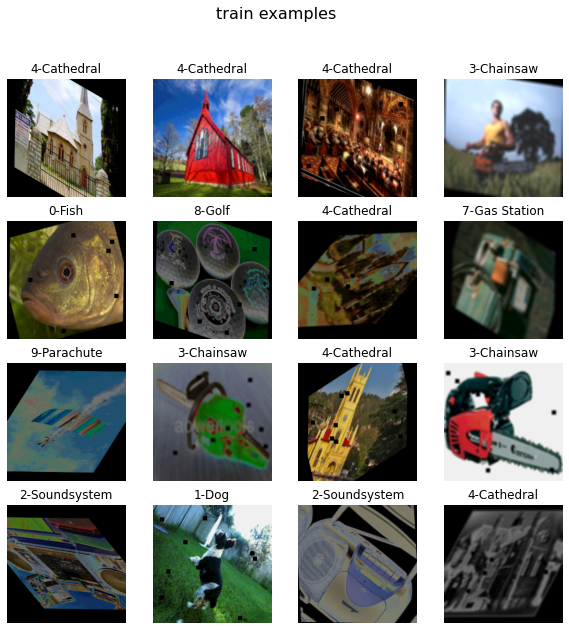

In [ ]:
train_ds, val_ds, test_ds = create_ds(kind='advanced')
show_examples(train_ds, 'train')
# show_examples(val_ds, 'validation')
# show_examples(val_ds, 'test')

Train counts:
0    932
1    930
2    916
3    849
4    912
5    194
6    181
7    180
8    189
9    178
Name: class_counts, dtype: int64
Val counts:
0    224
1    222
2    255
3    202
4    233
5     37
6     50
7     48
8     41
9     53
Name: class_counts, dtype: int64
Test counts:
0    194
1    198
2    179
3    193
4    205
5    197
6    195
7    210
8    200
9    195
Name: class_counts, dtype: int64


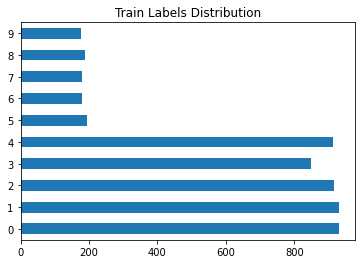

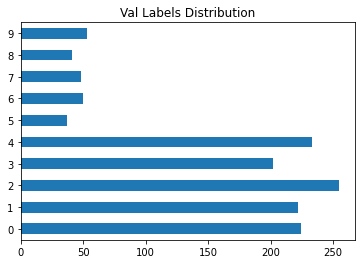

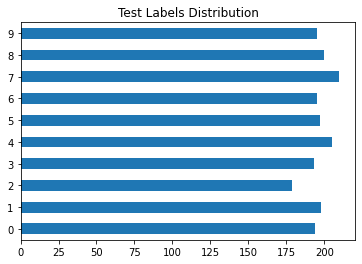

In [ ]:
show_class_dist(train_ds, title='Train')
show_class_dist(val_ds, title='Val')
show_class_dist(test_ds, title='Test')

In [ ]:
train_ds = rescale_and_encode_labels(train_ds)
val_ds = rescale_and_encode_labels(val_ds)
test_ds = rescale_and_encode_labels(test_ds)

# Modeling
## Model creation, initialization, and saving
After this phase, model shall be loaded from file, and not recreated, as we wish to load same weights over and over.

In [ ]:
# from keras.layers import Dense,Flatten, Dropout, Conv2D, MaxPool2D
# from keras.models import Model
# from keras.models import Sequential
# opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
# opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

# base_model = tf.keras.applications.EfficientNetB0(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=10,
#     classifier_activation="softmax",
# # )

# from google.colab import drive
# drive.mount('/content/drive')
# base_model.save(EFFICIENT_MODEL_PATH)



Mounted at /content/drive


## Loading pre-saved weights

In [ ]:
base_model = tf.keras.models.load_model(EFFICIENT_MODEL_PATH)
other_model = tf.keras.models.load_model(OTHER_MODEL_PATH)
model= tf.keras.models.clone_model(base_model)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])



## Creating Checkpoint

In [ ]:
# Creating model training CP - this one saves the best val_accuracy model state
def create_CP(path):
  cp = ModelCheckpoint(
      filepath=os.path.join(MODELS_PATH, path),
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)
  return cp

# Training
Each cell represent different augmentation scheme is 5 models trained on different splits of data. 

The split to different cells per aug type is derived from Google Colab limitations

In [ ]:
#no augs 
train_type = 'no_augs'
history_list = []
base = tf.keras.models.load_model(EFFICIENT_MODEL_PATH)
for i in range(FOLDS):
  print(f'set {i}/{FOLDS}')
  train_ds, val_ds, test_ds = create_ds(include_scale_encode=True, seed=i, kind=train_type)
  model= tf.keras.models.clone_model(base)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  STEPS_PER_EPOCH = len(list(train_ds))
  history = model.fit(
    train_ds.repeat(),
    epochs=EPOCHS,
    validation_data=val_ds, 
    steps_per_epoch = STEPS_PER_EPOCH,
    callbacks = [create_CP(train_type+ f'{i}')])
  history_list.append(history)

file = open(os.path.join(HISTORY_PATH, train_type + '.pkl'), 'wb')  
pickle.dump(history_list, file)          
file.close()


set 0/5
Found 6826 files belonging to 10 classes.
Using 5461 files for training.
Found 6826 files belonging to 10 classes.
Using 1365 files for validation.
Found 1966 files belonging to 10 classes.
Epoch 1/50
86/86 [==============================] - 74s 609ms/step - loss: 2.7434 - accuracy: 0.2395 - val_loss: 2.2025 - val_accuracy: 0.1626
Epoch 2/50
86/86 [==============================] - 53s 579ms/step - loss: 1.9323 - accuracy: 0.4107 - val_loss: 2.8550 - val_accuracy: 0.1626
Epoch 3/50
86/86 [==============================] - 56s 596ms/step - loss: 1.7147 - accuracy: 0.4931 - val_loss: 2.8530 - val_accuracy: 0.1641
Epoch 4/50
86/86 [==============================] - 53s 590ms/step - loss: 1.5019 - accuracy: 0.5461 - val_loss: 3.5805 - val_accuracy: 0.0388
Epoch 5/50
86/86 [==============================] - 54s 592ms/step - loss: 1.2765 - accuracy: 0.6006 - val_loss: 3.4795 - val_accuracy: 0.0388
Epoch 6/50
86/86 [==============================] - 54s 594ms/step - loss: 1.0911 - acc

In [ ]:
#randaugment run - 5 folds
train_type = 'randaugment'
history_list = []
base = tf.keras.models.load_model(EFFICIENT_MODEL_PATH)
for i in range(FOLDS):
  print(f'set {i}/{FOLDS}')
  train_ds, val_ds, test_ds = create_ds(include_scale_encode=True, seed=i, kind=train_type)
  model= tf.keras.models.clone_model(base)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  STEPS_PER_EPOCH = len(list(train_ds))
  history = model.fit(
    train_ds.repeat(),
    epochs=EPOCHS,
    validation_data=val_ds, 
    steps_per_epoch = STEPS_PER_EPOCH,
    callbacks = [create_CP(train_type+ f'_9_{i}')])
  history_list.append(history)

file = open(os.path.join(HISTORY_PATH,train_type +'_9.pkl'), 'wb')  
pickle.dump(history_list, file)          
file.close()

set 0/5
Found 6826 files belonging to 10 classes.
Using 5461 files for training.
Found 6826 files belonging to 10 classes.
Using 1365 files for validation.
Found 1966 files belonging to 10 classes.
Epoch 1/50
86/86 [==============================] - 60s 551ms/step - loss: 2.8421 - accuracy: 0.1954 - val_loss: 2.1509 - val_accuracy: 0.1626
Epoch 2/50
86/86 [==============================] - 49s 512ms/step - loss: 2.1151 - accuracy: 0.2598 - val_loss: 2.2222 - val_accuracy: 0.1626
Epoch 3/50
86/86 [==============================] - 47s 512ms/step - loss: 1.9325 - accuracy: 0.3426 - val_loss: 2.5569 - val_accuracy: 0.0388
Epoch 4/50
86/86 [==============================] - 48s 531ms/step - loss: 1.7491 - accuracy: 0.3992 - val_loss: 4.3262 - val_accuracy: 0.0388
Epoch 5/50
86/86 [==============================] - 48s 507ms/step - loss: 1.6416 - accuracy: 0.4481 - val_loss: 4.3542 - val_accuracy: 0.0388
Epoch 6/50
86/86 [==============================] - 50s 527ms/step - loss: 1.4773 - acc

In [ ]:
train_type = 'basic'
history_list = []
base = tf.keras.models.load_model(EFFICIENT_MODEL_PATH)
for i in range(FOLDS):
  print(f'set {i}/{FOLDS}')
  train_ds, val_ds, _ = create_ds(seed=i, kind=train_type)
  train_ds = rescale_and_encode_labels(train_ds, rescale=False)
  val_ds = rescale_and_encode_labels(val_ds)  
  model= tf.keras.models.clone_model(base)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  STEPS_PER_EPOCH = len(list(train_ds))
  print('steps per epoch: ' ,STEPS_PER_EPOCH)
  history = model.fit(
    train_ds.repeat(),
    epochs=EPOCHS,
    validation_data=val_ds, 
    steps_per_epoch = STEPS_PER_EPOCH,
    callbacks = [create_CP(train_type+ f'{i}')])
  history_list.append(history)

file = open(os.path.join(HISTORY_PATH,train_type +'.pkl'), 'wb')  
pickle.dump(history_list, file)     
file.close()

set 0/5
Found 6826 files belonging to 10 classes.
Using 5461 files for training.
Found 6826 files belonging to 10 classes.
Using 1365 files for validation.
Found 1966 files belonging to 10 classes.
steps per epoch:  86
Epoch 1/50
86/86 [==============================] - 47s 453ms/step - loss: 2.5220 - accuracy: 0.2793 - val_loss: 2.3442 - val_accuracy: 0.1626
Epoch 2/50
86/86 [==============================] - 38s 434ms/step - loss: 1.7828 - accuracy: 0.4016 - val_loss: 2.3383 - val_accuracy: 0.1626
Epoch 3/50
86/86 [==============================] - 38s 435ms/step - loss: 1.5843 - accuracy: 0.4790 - val_loss: 2.3478 - val_accuracy: 0.1626
Epoch 4/50
86/86 [==============================] - 38s 434ms/step - loss: 1.4248 - accuracy: 0.5334 - val_loss: 4.1221 - val_accuracy: 0.0388
Epoch 5/50
86/86 [==============================] - 38s 433ms/step - loss: 1.2902 - accuracy: 0.5812 - val_loss: 5.9546 - val_accuracy: 0.0388
Epoch 6/50
86/86 [==============================] - 37s 432ms/step

In [ ]:
train_type = 'advanced'
history_list = []
base = tf.keras.models.load_model(EFFICIENT_MODEL_PATH)
for i in range(FOLDS):
  print(f'set {i}/{FOLDS}')
  train_ds, val_ds, _ = create_ds(seed=i, kind=train_type)
  train_ds = rescale_and_encode_labels(train_ds, rescale=False)
  val_ds = rescale_and_encode_labels(val_ds)  
  model= tf.keras.models.clone_model(base)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  STEPS_PER_EPOCH = len(list(train_ds))
  print('steps per epoch: ' ,STEPS_PER_EPOCH)
  history = model.fit(
    train_ds.repeat(),
    epochs=EPOCHS,
    validation_data=val_ds, 
    steps_per_epoch = STEPS_PER_EPOCH,
    callbacks = [create_CP(train_type+ f'{i}')])
  history_list.append(history)

file = open(os.path.join(HISTORY_PATH,train_type +'.pkl'), 'wb')  
pickle.dump(history_list, file)          
file.close()

set 0/5
Found 6826 files belonging to 10 classes.
Using 5461 files for training.
Found 6826 files belonging to 10 classes.
Using 1365 files for validation.
Found 1966 files belonging to 10 classes.
here2
steps per epoch:  86
Epoch 1/50
86/86 [==============================] - 47s 453ms/step - loss: 3.0576 - accuracy: 0.1657 - val_loss: 2.1132 - val_accuracy: 0.1626
Epoch 2/50
86/86 [==============================] - 38s 434ms/step - loss: 2.2581 - accuracy: 0.1785 - val_loss: 2.0849 - val_accuracy: 0.1626
Epoch 3/50
86/86 [==============================] - 38s 441ms/step - loss: 2.1190 - accuracy: 0.1989 - val_loss: 2.0845 - val_accuracy: 0.1626
Epoch 4/50
86/86 [==============================] - 38s 434ms/step - loss: 2.0869 - accuracy: 0.2221 - val_loss: 2.0699 - val_accuracy: 0.1538
Epoch 5/50
86/86 [==============================] - 38s 434ms/step - loss: 2.0166 - accuracy: 0.2631 - val_loss: 2.0728 - val_accuracy: 0.1480
Epoch 6/50
86/86 [==============================] - 38s 439m

# Results Export and Initial Analysis
Full results analysis in different notebook

## Training history export

In [ ]:
aug_types = ['no_augs', 'ADC', 'randaugment', 'basic', 'advanced', 'randaugment_9_']
os.listdir(HISTORY_PATH)

['no_augs.pkl',
 'ADC.pkl',
 'randaugment.pkl',
 'basic.pkl',
 'advanced.pkl',
 'randaugment_9.pkl',
 'rgb_history_all.pkl']

In [ ]:
model_histories = {}
for file in os.listdir(HISTORY_PATH):
  filename = os.path.join(HISTORY_PATH, file)
  with open(filename, 'rb') as f:
      print(f'loading {filename}')
      history_cp = pickle.load(f)
      model_history = []
      for cp in history_cp:
          model_history.append(cp.history)
      model_histories[file.split('.')[0]] = model_history
      print(f'finished {filename}')

file = open(os.path.join(HISTORY_PATH, 'rgb_history_all.pkl'), 'wb')  
pickle.dump(model_histories, file)          
file.close()
del history_cp

loading /content/drive/My Drive/AugModels/all_types/no_augs.pkl
finished /content/drive/My Drive/AugModels/all_types/no_augs.pkl
loading /content/drive/My Drive/AugModels/all_types/ADC.pkl
finished /content/drive/My Drive/AugModels/all_types/ADC.pkl
loading /content/drive/My Drive/AugModels/all_types/randaugment.pkl
finished /content/drive/My Drive/AugModels/all_types/randaugment.pkl
loading /content/drive/My Drive/AugModels/all_types/basic.pkl
finished /content/drive/My Drive/AugModels/all_types/basic.pkl
loading /content/drive/My Drive/AugModels/all_types/advanced.pkl
finished /content/drive/My Drive/AugModels/all_types/advanced.pkl
loading /content/drive/My Drive/AugModels/all_types/randaugment_9.pkl
finished /content/drive/My Drive/AugModels/all_types/randaugment_9.pkl


## All predictions and true labels export

In [ ]:
y_true = list(test_ds.map(lambda x, y: y).as_numpy_iterator())
y_true = np.concatenate(y_true, axis = 0)
y_true = y_true.argmax(axis=1)
pd.Series(y_true).to_csv(os.path.join(HISTORY_PATH, 'true_labels.csv'))

In [ ]:
y_true_train = list(train_ds.map(lambda x, y: y).as_numpy_iterator())
y_true_train = np.concatenate(y_true_train, axis = 0)
y_true_train = y_true_train.argmax(axis=1)
pd.Series(y_true_train).to_csv(os.path.join(HISTORY_PATH, 'train_true_labels.csv'))

In [ ]:
all_preds = {}
model= tf.keras.models.clone_model(base_model)
for aug in aug_types:
  preds = np.zeros((FOLDS,len(y_true)))
  for i in range(FOLDS):
    path = os.path.join(MODELS_PATH, f'{aug}{i}')
    print(path)
    model.load_weights(path)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    y_pred = model.predict(test_ds)
    all_preds[f'{aug}{i}'] = y_pred.argmax(axis=1)

/content/drive/My Drive/AugModels/rgb/no_augs0
/content/drive/My Drive/AugModels/rgb/no_augs1
/content/drive/My Drive/AugModels/rgb/no_augs2
/content/drive/My Drive/AugModels/rgb/no_augs3
/content/drive/My Drive/AugModels/rgb/no_augs4
/content/drive/My Drive/AugModels/rgb/ADC0
/content/drive/My Drive/AugModels/rgb/ADC1
/content/drive/My Drive/AugModels/rgb/ADC2
/content/drive/My Drive/AugModels/rgb/ADC3
/content/drive/My Drive/AugModels/rgb/ADC4
/content/drive/My Drive/AugModels/rgb/randaugment0
/content/drive/My Drive/AugModels/rgb/randaugment1
/content/drive/My Drive/AugModels/rgb/randaugment2
/content/drive/My Drive/AugModels/rgb/randaugment3
/content/drive/My Drive/AugModels/rgb/randaugment4
/content/drive/My Drive/AugModels/rgb/basic0
/content/drive/My Drive/AugModels/rgb/basic1
/content/drive/My Drive/AugModels/rgb/basic2
/content/drive/My Drive/AugModels/rgb/basic3
/content/drive/My Drive/AugModels/rgb/basic4
/content/drive/My Drive/AugModels/rgb/advanced0
/content/drive/My Driv

In [ ]:
preds_df = pd.DataFrame(all_preds)
preds_df.head(10)

In [ ]:
# Ensemble (hard-voting) per aug type
for aug in aug_types:
  cols = [col for col in preds_df.columns if col.startswith(aug)]
  preds_df[f'{aug}_vote'] = mode(preds_df[cols], axis=1)[0]

In [ ]:
# preds_df['y_true'] = y_true
preds_df.to_csv(os.path.join(HISTORY_PATH, 'preds.csv'))

In [ ]:
preds_df = pd.read_csv(os.path.join(HISTORY_PATH, 'preds.csv'), index_col=0)

## Exporting all relevant metrics per model

In [ ]:
metrics = {}
for col in preds_df.columns:
  precision, recall, fscore, _ = precision_recall_fscore_support(y_true, preds_df[col])
  dict_col = {
      'precision':np.mean(precision), 
      'minority_precision': np.mean(precision[MINOR_CLASSES]), 
      'majority_precision':  np.mean(precision[MAJOR_CLASSES]),
      'recall': np.mean(recall), 
      'minority_recall': np.mean(recall[MINOR_CLASSES]), 
      'majority_recall': np.mean(recall[MAJOR_CLASSES]),
      'fscore': np.mean(fscore), 
      'minority_fscore': np.mean(fscore[MINOR_CLASSES]), 
      'majority_fscore': np.mean(fscore[MAJOR_CLASSES]),
      'accuracy': accuracy_score(y_true, preds_df[col])
      }
  metrics[col] = pd.Series(dict_col)

In [ ]:
results_df = pd.DataFrame(metrics).T
results_df

,precision,minority_precision,majority_precision,recall,minority_recall,majority_recall,fscore,minority_fscore,majority_fscore,accuracy
no_augs0,0.683288,0.793487,0.573090,0.624737,0.402945,0.846529,0.600403,0.519954,0.680852,0.621058
no_augs1,0.682551,0.801787,0.563316,0.620989,0.385297,0.856680,0.594401,0.512305,0.676498,0.616989
no_augs2,0.674682,0.809934,0.539430,0.576442,0.309920,0.842963,0.545182,0.439434,0.650929,0.573245
no_augs3,0.680203,0.840043,0.520364,0.577969,0.313028,0.842909,0.539558,0.440156,0.638960,0.573245
no_augs4,0.672673,0.785367,0.559980,0.606082,0.348528,0.863636,0.574173,0.472202,0.676143,0.601729
ADC0,0.690216,0.805656,0.574775,0.632649,0.429209,0.836090,0.614991,0.552515,0.677468,0.629196
ADC1,0.676531,0.809539,0.543522,0.594919,0.344752,0.845087,0.563011,0.469718,0.656304,0.591048
ADC2,0.683663,0.820415,0.546911,0.604405,0.369596,0.839214,0.580946,0.503487,0.658406,0.600203
ADC3,0.704284,0.806976,0.601591,0.633592,0.432660,0.834524,0.619703,0.550610,0.688796,0.631231
ADC4,0.680608,0.805428,0.555788,0.617089,0.395555,0.838623,0.595048,0.524436,0.665660,0.613428


In [ ]:
results_df.to_csv(os.path.join(HISTORY_PATH, 'metrics.csv'))

## Exporting model's last dense layer for 2D visualizations

In [ ]:
from keras.models import Model

dnn_preds_test = {}
dnn_preds_train ={}
for aug in aug_types:
  model= tf.keras.models.clone_model(base_model)
  model.load_weights(os.path.join(MODELS_PATH,f'{aug}{0}'))
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  model2 = Model(model.input, model.layers[-3].output)
  dnn_preds_test[f'{aug}'] = model2.predict(test_ds)
  dnn_preds_train[f'{aug}'] = model2.predict(train_ds)

In [ ]:
file = open(os.path.join(HISTORY_PATH, 'test_rgb_high_dimension_rep.pkl'), 'wb')  
pickle.dump(dnn_preds_test, file)
file.close()

file = open(os.path.join(HISTORY_PATH, 'train_rgb_high_dimension_rep.pkl'), 'wb')  
pickle.dump(dnn_preds_train, file)
file.close()